In [2]:
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd

In [3]:
def brayton(T1gt, P1gt, rp, T3gt, P4gt, Tex):
    air = ct.Solution('air.yaml')
    
    #1 Compressor Inlet
    T1gt = T1gt
    P1gt = P1gt
    air.TP = T1gt, P1gt
    s1gt = air.entropy_mass
    h1gt = air.enthalpy_mass
    
    #2 Compressor outlet
    P2gt = P1gt * rp
    air.SP = s1gt, P2gt #isentropic compression
    h2gt = ((air.enthalpy_mass - h1gt)/0.80) + h1gt
    air.HP = h2gt, P2gt
    T2gt = air.T
    s2gt = air.entropy_mass
    
    #3 Turbine inlet
    T3gt = T3gt
    P3gt = P2gt
    air.TP = T3gt, P3gt
    s3gt = air.entropy_mass
    h3gt = air.enthalpy_mass
    
    #4 Turbine outlet
    P4gt = P4gt
    air.SP = s3gt, P4gt
    h4gt = h3gt - ((h3gt - air.enthalpy_mass) * 0.75) #isentropic expansion
    air.HP = h4gt, P4gt
    T4gt = air.T
    s4gt = air.entropy_mass

    #5 Heat Exchanger Outlet
    P5gt = P4gt
    T5gt = Tex
    air.TP = T5gt, P5gt
    h5gt = air.enthalpy_mass
    s5gt = air.entropy_mass
    
    # Heat Exchanger Average Temperature
    Hx1_T = (T2gt+T3gt)/2
    Hx2_T = (T4gt+T5gt)/2
    
    return T4gt, h1gt, h2gt, h3gt, h4gt, h5gt, s1gt, s2gt, s3gt, s4gt, s5gt, rp, Hx1_T, Hx2_T
    

In [30]:
def rankine(P1st, P2st, T4gt, h4gt, h5gt):
    water = ct.Solution('water.yaml')
    
    #1 Pump inlet
    P1st = P1st
    wtr = ct.Water()
    
    Q1st = 0
    wtr.PQ = P1st, Q1st
    T1st = wtr.T
    h1st = wtr.enthalpy_mass
    s1st = wtr.entropy_mass
    
    #2 Pump outlet
    P2st = P2st
    wtr.SP = s1st, P2st
    h2st = h1st + ((wtr.enthalpy_mass - h1st) / 0.90)
    wtr.HP = h2st, P2st
    T2st = wtr.T
    s2st = wtr.entropy_mass
    
    #3 Boiler Outlet
    P3st = P2st
    
    inlet_h = h4gt
    outlet_h = h5gt
    
    theoretical_max = ct.Water()
    theoretical_max.TP = T4gt, P2st # Theoretical Max outlet temp is the same as the turbine inlet
    h3st_max = theoretical_max.enthalpy_mass # Theoretical Max
    
    h3st = h2st + (0.82 * (h3st_max - h2st)) # Actual enthalpy of steam)
    
    mr = (inlet_h - outlet_h) / (h3st - h2st) # Mass Ratio of Steam to Air

    wtr.HP = h3st, P3st
    T3st = wtr.T
    s3st = wtr.entropy_mass
  
    #3 Turbine Outlet
    P4st = P1st
    wtr.SP = s3st, P4st
    h4st = h3st - 0.85 * (h3st - wtr.enthalpy_mass)
    wtr.HP = h4st, P4st
    s4st = wtr.entropy_mass
    T4st = wtr.T
    
    # Heat Exchanger Average Temperature
    Hx3_T = (T2st+T3st)/2
    Hx4_T = (T4st+T1st)/2
    
    return mr, h1st, h2st, h3st, h4st, s1st, s2st, s3st, s4st, Hx3_T, Hx4_T

In [31]:
def combined(T1gt, P1gt, rp, T3gt, P4gt, Tex, P1st, P2st):
    T4gt, h1gt, h2gt, h3gt, h4gt, h5gt, s1gt, s2gt, s3gt, s4gt, s5gt, rp, Hx1_T, Hx2_T = brayton(T1gt, P1gt, rp, T3gt, P4gt, Tex)
    mr, h1st, h2st, h3st, h4st, s1st, s2st, s3st, s4st, Hx3_T, Hx4_T = rankine(P1st, P2st, T4gt, h4gt, h5gt)
    return h1gt, h2gt, h3gt, h4gt, h5gt, s1gt, s2gt, s3gt, s4gt, s5gt, h1st, h2st, h3st, h4st, s1st, s2st, s3st, s4st, mr, rp, Hx1_T, Hx2_T, Hx3_T, Hx4_T

In [32]:
# Work, Heat, Enthalpy Change, and Exergy Change for each component
def component_analysis(hin, sin, hout, sout, Component, To, heat_temp = 0):
    if Component == "Producer":
        # Work
        work = abs(hout - hin)
        rev_work = abs(hout - hin) + abs(To*(sout - sin))
        # Heat
        heat = 0
        # Enthalpy Change
        enthalpy_change = hout - hin
        # Exergy Change
        exergy_change = hout - hin - To*(sout - sin)
        #Irreversibility
        irreversibility = To*(sout - sin)
        # Second Law Efficiency
        second_law_efficiency = work/rev_work
        return work, heat, enthalpy_change, exergy_change, irreversibility, second_law_efficiency
    
    elif Component == "Consumer":
        # Work
        work = abs(hout - hin)
        rev_work = abs(hout - hin) - abs(To*(sout - sin))
        # Heat
        heat = 0
        # Enthalpy Change
        enthalpy_change = hout - hin
        # Exergy Change
        exergy_change = hout - hin - To*(sout - sin)
        # Irreversibility
        irreversibility = To*(sout - sin)
        # Second Law Efficiency
        second_law_efficiency = rev_work/work
        return work, heat, enthalpy_change, exergy_change, irreversibility, second_law_efficiency
    
    elif Component == "Exchanger":
        # Work
        work = 0
        # Heat
        heat = hout - hin
        # Enthalpy Change
        enthalpy_change = hout - hin
        # Exergy Change
        exergy_change = hout - hin - To*(sout - sin)
        # Irreversibility
        average_temperature = heat_temp
        irreversibility = To*(sout - sin - heat/average_temperature)
        return work, heat, enthalpy_change, exergy_change, irreversibility
    
    else:
        print("Error: Component not defined")
        return 0, 0, 0, 0, 0

In [65]:
rp_range = np.linspace(2, 20, 100)

brayton_cycle_compressor = pd.DataFrame(columns=["Pressure Ratio", "Component", "Work", "Heat", "Enthalpy Change", "Exergy Change", "Irreversibility", "Second Law Efficiency"])
brayton_cycle_hx = pd.DataFrame(columns=["Pressure Ratio", "Component", "Work", "Heat", "Enthalpy Change", "Exergy Change", "Irreversibility"])
brayton_cycle_turbine = pd.DataFrame(columns=["Pressure Ratio", "Component", "Work", "Heat", "Enthalpy Change", "Exergy Change", "Irreversibility", "Second Law Efficiency"])
brayton_cycle_hx2 = pd.DataFrame(columns=["Pressure Ratio", "Component", "Work", "Heat", "Enthalpy Change", "Exergy Change", "Irreversibility"])

rankine_cycle_pump = pd.DataFrame(columns=["Pressure Ratio", "Component", "Work", "Heat", "Enthalpy Change", "Exergy Change", "Irreversibility", "Second Law Efficiency"])
rankine_cycle_boiler = pd.DataFrame(columns=["Pressure Ratio", "Component", "Work", "Heat", "Enthalpy Change", "Exergy Change", "Irreversibility"])
rankine_cycle_turbine = pd.DataFrame(columns=["Pressure Ratio", "Component", "Work", "Heat", "Enthalpy Change", "Exergy Change", "Irreversibility", "Second Law Efficiency"])
rankine_cycle_condenser = pd.DataFrame(columns=["Pressure Ratio", "Component", "Work", "Heat", "Enthalpy Change", "Exergy Change", "Irreversibility"])

efficiency = pd.DataFrame(columns=["Pressure Ratio", "Mass Ratio", "Thermal Efficinency", "Net Work", "Net Work per Unit Mass", "Heat Into System"])


for rp in rp_range:
    h1gt, h2gt, h3gt, h4gt, h5gt, s1gt, s2gt, s3gt, s4gt, s5gt, h1st, h2st, h3st, h4st, s1st, s2st, s3st, s4st, mr, rp, Hx1_T, Hx2_T, Hx3_T, Hx4_T = combined(300, 101325, rp, 1450, 101325, 450, 5E3, 7E6)
    
    compressor_brayton = component_analysis(h1gt, s1gt, h2gt, s2gt, "Consumer", 300)
    hx_brayton = component_analysis(h2gt, s2gt, h3gt, s3gt, "Exchanger", 300, Hx1_T)
    turbine_brayton = component_analysis(h3gt, s3gt, h4gt, s4gt, "Producer",300)
    hx2_brayton = component_analysis(h4gt, s4gt, h5gt, s5gt, "Exchanger", 300, Hx2_T)
    
    pump_rankine = component_analysis(h1st, s1st, h2st, s2st, "Consumer", 300)
    boiler_rankine = component_analysis(h2st, s2st, h3st, s3st, "Exchanger", 300, Hx3_T)
    turbine_rankine = component_analysis(h3st, s3st, h4st, s4st, "Producer", 300)
    condenser_rankine = component_analysis(h4st, s4st, h1st, s1st, "Exchanger", 300, Hx4_T)
    
    #Thermal Efficiency
    work_net = - compressor_brayton[0] - (pump_rankine[0]*mr) + turbine_brayton[0] + (turbine_rankine[0]*mr) # kgs / kga * (1/kgs) = 1 / kga
    q_in = hx_brayton[1]
    thermal_eff = work_net / q_in
    work_net_unit_mass = 0 # this is incorrect
    
    # Make a dataframe for the Brayton Cycle
    brayton_cycle_compressor.loc[len(brayton_cycle_compressor)] = [rp, "Compressor", compressor_brayton[0], compressor_brayton[1], compressor_brayton[2], compressor_brayton[3], compressor_brayton[4], compressor_brayton[5]]
    brayton_cycle_hx.loc[len(brayton_cycle_hx)] = [rp, "Heat Exchanger", hx_brayton[0], hx_brayton[1], hx_brayton[2], hx_brayton[3], hx_brayton[4]]
    brayton_cycle_turbine.loc[len(brayton_cycle_turbine)] = [rp, "Turbine", turbine_brayton[0], turbine_brayton[1], turbine_brayton[2], turbine_brayton[3], turbine_brayton[4], turbine_brayton[5]]
    brayton_cycle_hx2.loc[len(brayton_cycle_hx2)] = [rp, "Heat Exchanger", hx2_brayton[0], hx2_brayton[1], hx2_brayton[2], hx2_brayton[3], hx2_brayton[4]]
    
    # Make a dataframe for the Rankine Cycle
    rankine_cycle_pump.loc[len(rankine_cycle_pump)] = [rp, "Pump", pump_rankine[0] * mr, pump_rankine[1] * mr, pump_rankine[2] * mr, pump_rankine[3] * mr, pump_rankine[4] * mr, pump_rankine[5]]
    rankine_cycle_boiler.loc[len(rankine_cycle_boiler)] = [rp, "Boiler", boiler_rankine[0] * mr, boiler_rankine[1] * mr, boiler_rankine[2] * mr, boiler_rankine[3] * mr, boiler_rankine[4]]
    rankine_cycle_turbine.loc[len(rankine_cycle_turbine)] = [rp, "Turbine", turbine_rankine[0] * mr, turbine_rankine[1] * mr, turbine_rankine[2] * mr, turbine_rankine[3] * mr, turbine_rankine[4] * mr, turbine_rankine[5]]
    rankine_cycle_condenser.loc[len(rankine_cycle_condenser)] = [rp, "Condenser", condenser_rankine[0] * mr, condenser_rankine[1] * mr, condenser_rankine[2] * mr, condenser_rankine[3] * mr, condenser_rankine[4]]
    
    # Make a dataframe for the Thermal Efficiency, Net Work, and Pressure Ratio
    efficiency.loc[len(efficiency)] = [rp, mr, thermal_eff, work_net, work_net_unit_mass, q_in]

In [66]:
print(rankine_cycle_turbine)

    Pressure Ratio Component           Work  Heat  Enthalpy Change  \
0         2.000000   Turbine  342872.924615   0.0   -342872.924615   
1         2.181818   Turbine  332457.136575   0.0   -332457.136575   
2         2.363636   Turbine  323162.160052   0.0   -323162.160052   
3         2.545455   Turbine  314794.512829   0.0   -314794.512829   
4         2.727273   Turbine  307204.968680   0.0   -307204.968680   
..             ...       ...            ...   ...              ...   
95       19.272727   Turbine  155193.610253   0.0   -155193.610253   
96       19.454545   Turbine  154690.521229   0.0   -154690.521229   
97       19.636364   Turbine  154193.727578   0.0   -154193.727578   
98       19.818182   Turbine  153703.092349   0.0   -153703.092349   
99       20.000000   Turbine  153218.482799   0.0   -153218.482799   

    Exergy Change  Irreversibility  Second Law Efficiency  
0  -402180.437161     59307.512547               0.852535  
1  -389963.006485     57505.869910     

In [67]:
brayton_cycle_hx

,Pressure Ratio,Component,Work,Heat,Enthalpy Change,Exergy Change,Irreversibility
0,2.000000,Heat Exchanger,0,1.192264e+06,1.192264e+06,754606.330993,47150.831676
1,2.181818,Heat Exchanger,0,1.180711e+06,1.180711e+06,751996.503662,44383.634705
2,2.363636,Heat Exchanger,0,1.169828e+06,1.169828e+06,749304.235714,41938.255121
3,2.545455,Heat Exchanger,0,1.159530e+06,1.159530e+06,746558.866587,39758.138660
4,2.727273,Heat Exchanger,0,1.149746e+06,1.149746e+06,743781.514158,37799.729363
...,...,...,...,...,...,...,...
95,19.272727,Heat Exchanger,0,7.773769e+05,7.773769e+05,562363.698993,5649.094956
96,19.454545,Heat Exchanger,0,7.750641e+05,7.750641e+05,560941.665013,5579.449984
97,19.636364,Heat Exchanger,0,7.727669e+05,7.727669e+05,559526.930609,5511.033781
98,19.818182,Heat Exchanger,0,7.704853e+05,7.704853e+05,558119.404449,5443.815536


In [68]:
brayton_cycle_hx

,Pressure Ratio,Component,Work,Heat,Enthalpy Change,Exergy Change,Irreversibility
0,2.000000,Heat Exchanger,0,1.192264e+06,1.192264e+06,754606.330993,47150.831676
1,2.181818,Heat Exchanger,0,1.180711e+06,1.180711e+06,751996.503662,44383.634705
2,2.363636,Heat Exchanger,0,1.169828e+06,1.169828e+06,749304.235714,41938.255121
3,2.545455,Heat Exchanger,0,1.159530e+06,1.159530e+06,746558.866587,39758.138660
4,2.727273,Heat Exchanger,0,1.149746e+06,1.149746e+06,743781.514158,37799.729363
...,...,...,...,...,...,...,...
95,19.272727,Heat Exchanger,0,7.773769e+05,7.773769e+05,562363.698993,5649.094956
96,19.454545,Heat Exchanger,0,7.750641e+05,7.750641e+05,560941.665013,5579.449984
97,19.636364,Heat Exchanger,0,7.727669e+05,7.727669e+05,559526.930609,5511.033781
98,19.818182,Heat Exchanger,0,7.704853e+05,7.704853e+05,558119.404449,5443.815536


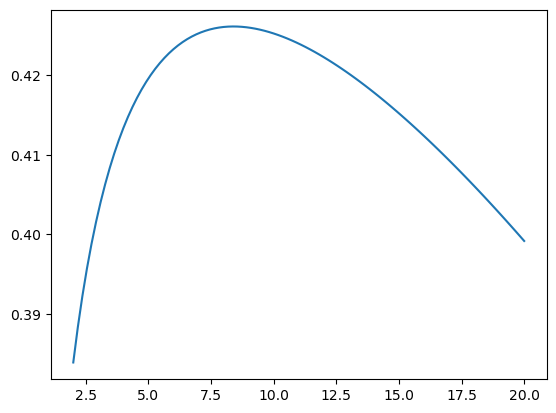

In [69]:
plt.plot(efficiency["Pressure Ratio"], efficiency["Thermal Efficinency"])

In [70]:
efficiency

,Pressure Ratio,Mass Ratio,Thermal Efficinency,Net Work,Net Work per Unit Mass,Heat Into System
0,2.000000,0.250362,0.383911,457723.838802,0.0,1.192264e+06
1,2.181818,0.246841,0.388341,458518.734135,0.0,1.180711e+06
2,2.363636,0.243597,0.392244,458858.770589,0.0,1.169828e+06
3,2.545455,0.240591,0.395707,458833.925442,0.0,1.159530e+06
4,2.727273,0.237792,0.398795,458512.831158,0.0,1.149746e+06
...,...,...,...,...,...,...
95,19.272727,0.160969,0.401759,312318.006196,0.0,7.773769e+05
96,19.454545,0.160624,0.401120,310893.686970,0.0,7.750641e+05
97,19.636364,0.160283,0.400477,309475.028595,0.0,7.727669e+05
98,19.818182,0.159946,0.399828,308061.985455,0.0,7.704853e+05


In [71]:
rankine_cycle_pump

,Pressure Ratio,Component,Work,Heat,Enthalpy Change,Exergy Change,Irreversibility,Second Law Efficiency
0,2.000000,Pump,1953.134330,0.0,1953.134330,1761.858903,191.275428,0.902067
1,2.181818,Pump,1925.662901,0.0,1925.662901,1737.077820,188.585080,0.902067
2,2.363636,Pump,1900.357928,0.0,1900.357928,1714.251028,186.106900,0.902067
3,2.545455,Pump,1876.908786,0.0,1876.908786,1693.098320,183.810466,0.902067
4,2.727273,Pump,1855.067259,0.0,1855.067259,1673.395790,181.671469,0.902067
...,...,...,...,...,...,...,...,...
95,19.272727,Pump,1255.753821,0.0,1255.753821,1132.774646,122.979175,0.902067
96,19.454545,Pump,1253.067094,0.0,1253.067094,1130.351037,122.716057,0.902067
97,19.636364,Pump,1250.407925,0.0,1250.407925,1127.952287,122.455638,0.902067
98,19.818182,Pump,1247.775790,0.0,1247.775790,1125.577924,122.197866,0.902067


In [72]:
rankine_cycle_turbine

,Pressure Ratio,Component,Work,Heat,Enthalpy Change,Exergy Change,Irreversibility,Second Law Efficiency
0,2.000000,Turbine,342872.924615,0.0,-342872.924615,-402180.437161,59307.512547,0.852535
1,2.181818,Turbine,332457.136575,0.0,-332457.136575,-389963.006485,57505.869910,0.852535
2,2.363636,Turbine,323162.160052,0.0,-323162.160052,-379060.256652,55898.096601,0.852535
3,2.545455,Turbine,314794.512829,0.0,-314794.512829,-369245.238386,54450.725557,0.852535
4,2.727273,Turbine,307204.968680,0.0,-307204.968680,-360342.913459,53137.944779,0.852535
...,...,...,...,...,...,...,...,...
95,19.272727,Turbine,155193.610253,0.0,-155193.610253,-182037.803324,26844.193071,0.852535
96,19.454545,Turbine,154690.521229,0.0,-154690.521229,-181447.693843,26757.172614,0.852535
97,19.636364,Turbine,154193.727578,0.0,-154193.727578,-180864.968660,26671.241082,0.852535
98,19.818182,Turbine,153703.092349,0.0,-153703.092349,-180289.467135,26586.374786,0.852535


In [73]:
optimum_ratio = efficiency["Pressure Ratio"][np.argmax(efficiency["Thermal Efficinency"])]
print(optimum_ratio)

8.363636363636363


In [74]:
brayton_cycle_opt = pd.concat([brayton_cycle_compressor[brayton_cycle_compressor["Pressure Ratio"] == optimum_ratio], brayton_cycle_hx[brayton_cycle_hx["Pressure Ratio"] == optimum_ratio], brayton_cycle_turbine[brayton_cycle_turbine["Pressure Ratio"] == optimum_ratio], brayton_cycle_hx2[brayton_cycle_hx2["Pressure Ratio"] == optimum_ratio]])
print(brayton_cycle_opt)

    Pressure Ratio       Component           Work           Heat  \
35        8.363636      Compressor  313602.622096       0.000000   
35        8.363636  Heat Exchanger       0.000000  961155.367750   
35        8.363636         Turbine  517374.698571       0.000000   
35        8.363636  Heat Exchanger       0.000000 -605587.055233   

    Enthalpy Change  Exergy Change  Irreversibility  Second Law Efficiency  
35    313602.622096  280920.175182     32682.446914               0.895784  
35    961155.367750  666121.599399     14568.545727                    NaN  
35   -517374.698571 -572887.086224     55512.387653               0.903101  
35   -605587.055233 -345376.774094    -11361.160914                    NaN  


In [75]:
rankine_cycle_opt = pd.concat([rankine_cycle_pump[rankine_cycle_pump["Pressure Ratio"] == optimum_ratio], rankine_cycle_boiler[rankine_cycle_boiler["Pressure Ratio"] == optimum_ratio], rankine_cycle_turbine[rankine_cycle_turbine["Pressure Ratio"] == optimum_ratio], rankine_cycle_condenser[rankine_cycle_condenser["Pressure Ratio"] == optimum_ratio]])
print(rankine_cycle_opt)

    Pressure Ratio  Component           Work           Heat  Enthalpy Change  \
35        8.363636       Pump    1503.865249       0.000000      1503.865249   
35        8.363636     Boiler       0.000000  605587.055233    605587.055233   
35        8.363636    Turbine  207299.030759       0.000000   -207299.030759   
35        8.363636  Condenser       0.000000 -399791.889723   -399791.889723   

    Exergy Change  Irreversibility  Second Law Efficiency  
35    1356.587888       147.277360               0.902067  
35  249724.795847     15407.653176                    NaN  
35 -243156.017371     35856.986612               0.852535  
35   -7925.366365         0.000614                    NaN  


In [76]:
second_law_efficiency = brayton_cycle_compressor[["Pressure Ratio", "Second Law Efficiency"]],brayton_cycle_turbine[["Pressure Ratio", "Second Law Efficiency"]], rankine_cycle_pump[["Pressure Ratio", "Second Law Efficiency"]], rankine_cycle_turbine[["Pressure Ratio", "Second Law Efficiency"]]
print(second_law_efficiency[0])

    Pressure Ratio  Second Law Efficiency
0         2.000000               0.839425
1         2.181818               0.843715
2         2.363636               0.847547
3         2.545455               0.850999
4         2.727273               0.854132
..             ...                    ...
95       19.272727               0.917918
96       19.454545               0.918133
97       19.636364               0.918345
98       19.818182               0.918555
99       20.000000               0.918762

[100 rows x 2 columns]


In [77]:
print(second_law_efficiency[1])

    Pressure Ratio  Second Law Efficiency
0         2.000000               0.926191
1         2.181818               0.924941
2         2.363636               0.923774
3         2.545455               0.922680
4         2.727273               0.921648
..             ...                    ...
95       19.272727               0.886939
96       19.454545               0.886746
97       19.636364               0.886554
98       19.818182               0.886363
99       20.000000               0.886174

[100 rows x 2 columns]


In [78]:
print(second_law_efficiency[2])

    Pressure Ratio  Second Law Efficiency
0         2.000000               0.902067
1         2.181818               0.902067
2         2.363636               0.902067
3         2.545455               0.902067
4         2.727273               0.902067
..             ...                    ...
95       19.272727               0.902067
96       19.454545               0.902067
97       19.636364               0.902067
98       19.818182               0.902067
99       20.000000               0.902067

[100 rows x 2 columns]


In [79]:
print(second_law_efficiency[3])

    Pressure Ratio  Second Law Efficiency
0         2.000000               0.852535
1         2.181818               0.852535
2         2.363636               0.852535
3         2.545455               0.852535
4         2.727273               0.852535
..             ...                    ...
95       19.272727               0.852535
96       19.454545               0.852535
97       19.636364               0.852535
98       19.818182               0.852535
99       20.000000               0.852535

[100 rows x 2 columns]


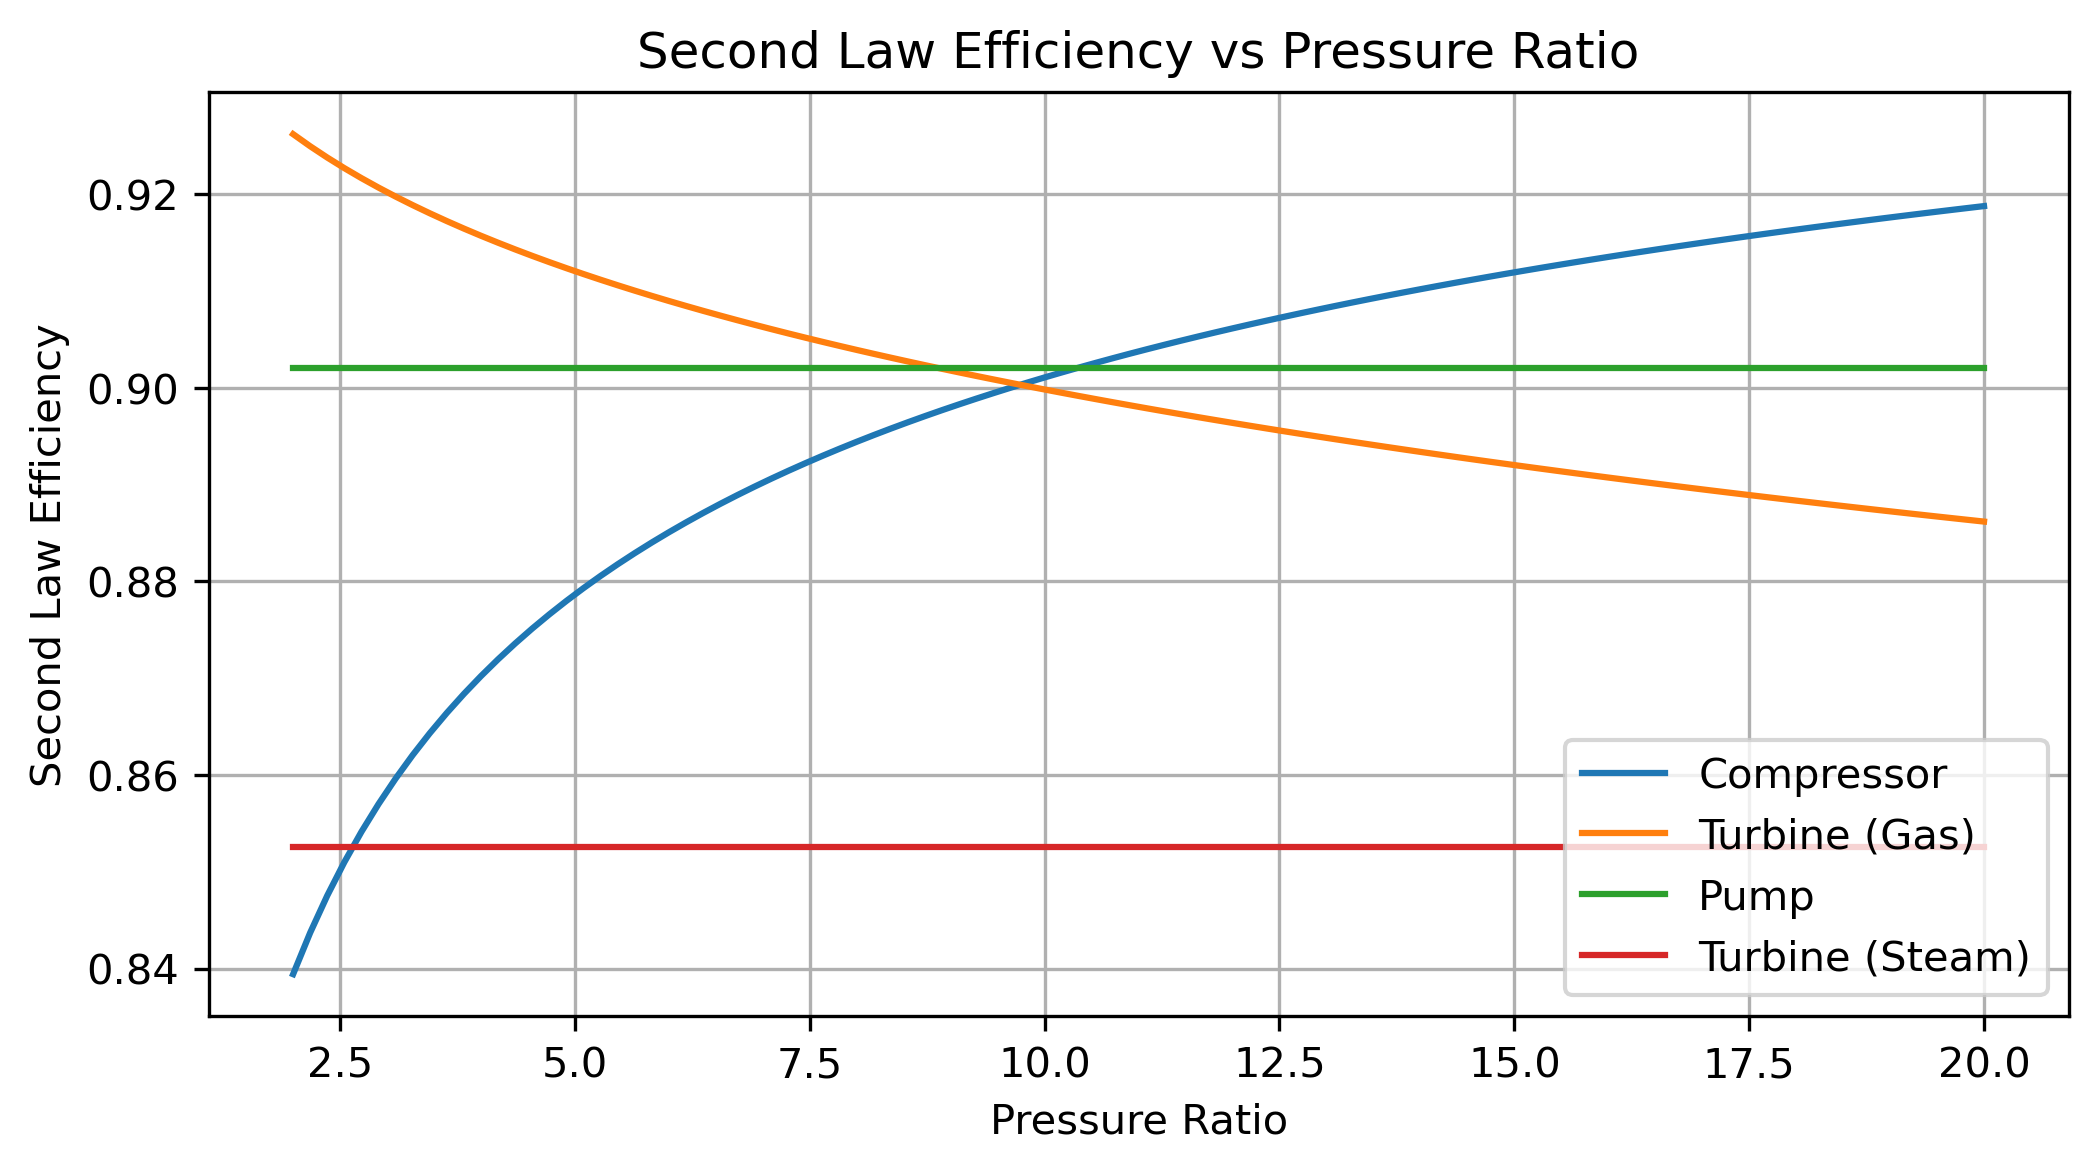

In [80]:
fig = plt.figure(figsize= (8,4), dpi=300)
ax = fig.add_subplot(111)
ax.plot(second_law_efficiency[0]["Pressure Ratio"], second_law_efficiency[0]["Second Law Efficiency"], label="Compressor")
ax.plot(second_law_efficiency[1]["Pressure Ratio"], second_law_efficiency[1]["Second Law Efficiency"], label="Turbine (Gas)")
ax.plot(second_law_efficiency[2]["Pressure Ratio"], second_law_efficiency[2]["Second Law Efficiency"], label="Pump")
ax.plot(second_law_efficiency[3]["Pressure Ratio"], second_law_efficiency[3]["Second Law Efficiency"], label="Turbine (Steam)")
ax.set_xlabel("Pressure Ratio")
ax.set_ylabel("Second Law Efficiency")
ax.set_title("Second Law Efficiency vs Pressure Ratio")
ax.legend(loc = "lower right")
ax.grid()
plt.savefig("Second Law Efficiency vs Pressure Ratio.png", dpi=300)

In [88]:
optimum_ratio_values = pd.DataFrame(columns=["Component", "Work", "Heat", "Enthalpy Change", "Exergy Change", "Irreversibility", "Second Law Efficiency"])
optimum_ratio_values = pd.concat([optimum_ratio_values, brayton_cycle_opt, rankine_cycle_opt],ignore_index=True)
optimum_ratio_values.to_excel("Optimum Pressure Ratio.xlsx")

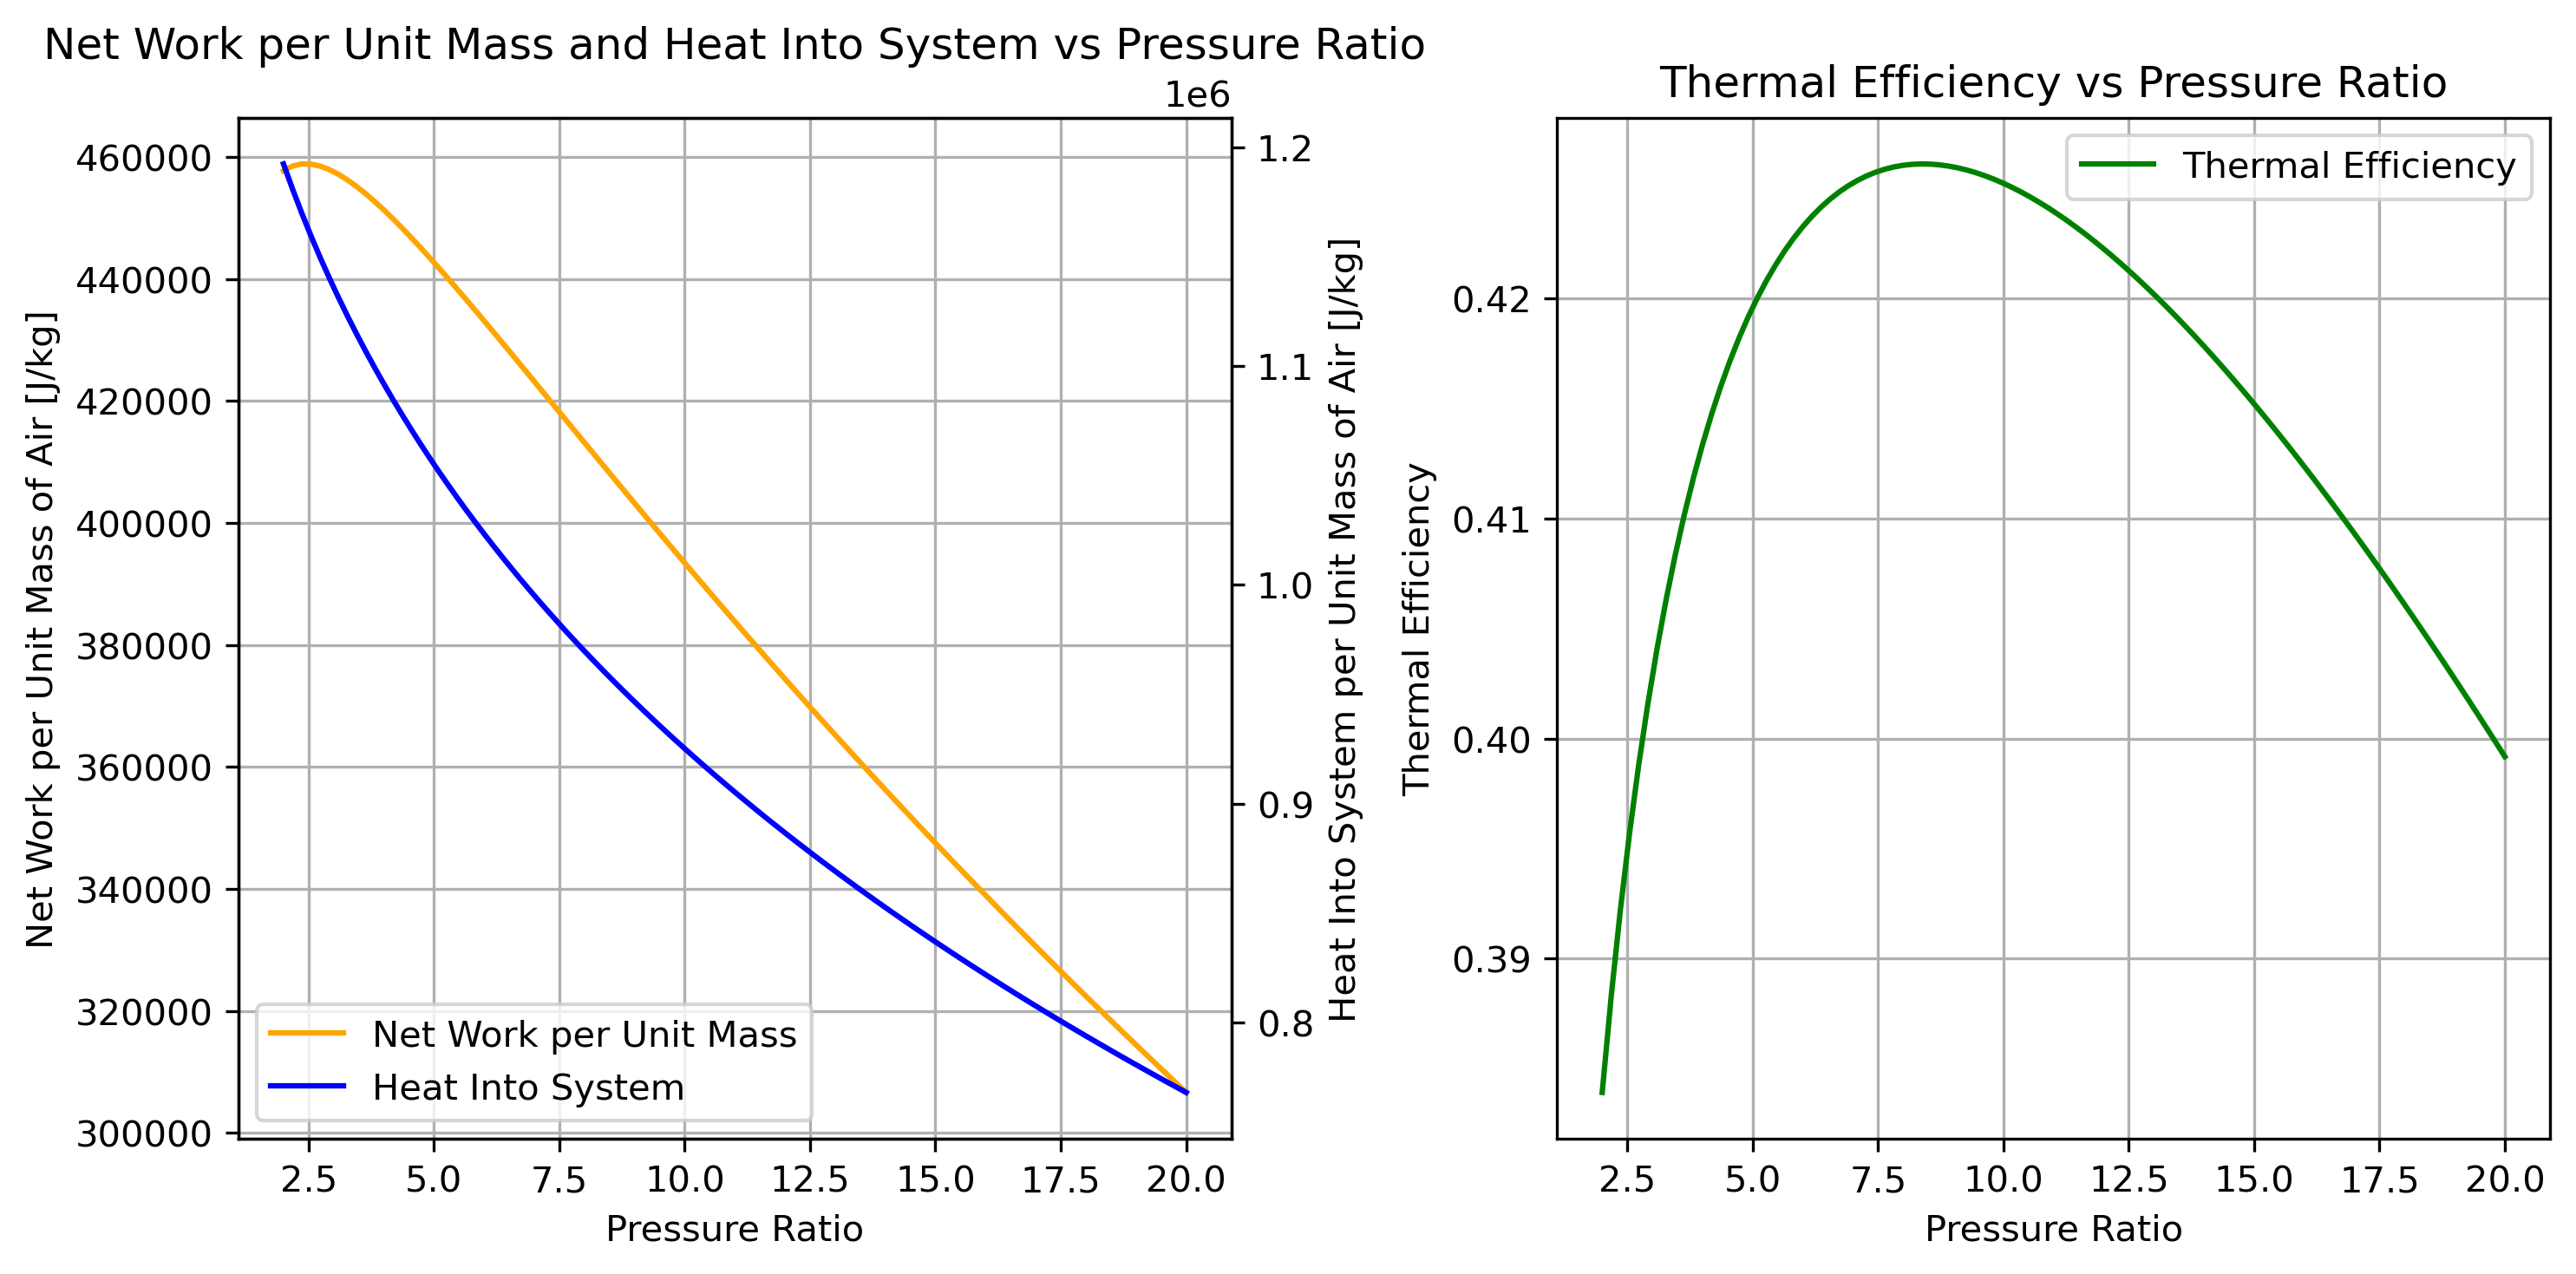

In [82]:
fig = plt.figure(figsize= (10,5), dpi=300)
fig.set_tight_layout(True)
ax = fig.add_subplot(121)

ax.plot(efficiency["Pressure Ratio"], efficiency["Net Work"], label="Net Work per Unit Mass", color="orange")
# Make a second axis
ax2 = ax.twinx()

ax2.plot(efficiency["Pressure Ratio"], efficiency["Heat Into System"], label="Heat Into System", color="blue")
ax.set_xlabel("Pressure Ratio")
ax.set_ylabel("Net Work per Unit Mass of Air [J/kg]")
ax2.set_ylabel("Heat Into System per Unit Mass of Air [J/kg]")
ax.set_title("Net Work per Unit Mass and Heat Into System vs Pressure Ratio")

legend1 = ax.get_legend_handles_labels()
legend2 = ax2.get_legend_handles_labels()
ax.legend(legend1[0] + legend2[0], legend1[1] + legend2[1], loc= "lower left")

ax.grid()

ax3 = fig.add_subplot(122)
ax3.plot(efficiency["Pressure Ratio"], efficiency["Thermal Efficinency"], label="Thermal Efficiency", color="green")
ax3.set_xlabel("Pressure Ratio")
ax3.set_ylabel("Thermal Efficiency")
ax3.set_title("Thermal Efficiency vs Pressure Ratio")
ax3.legend()
ax3.grid()


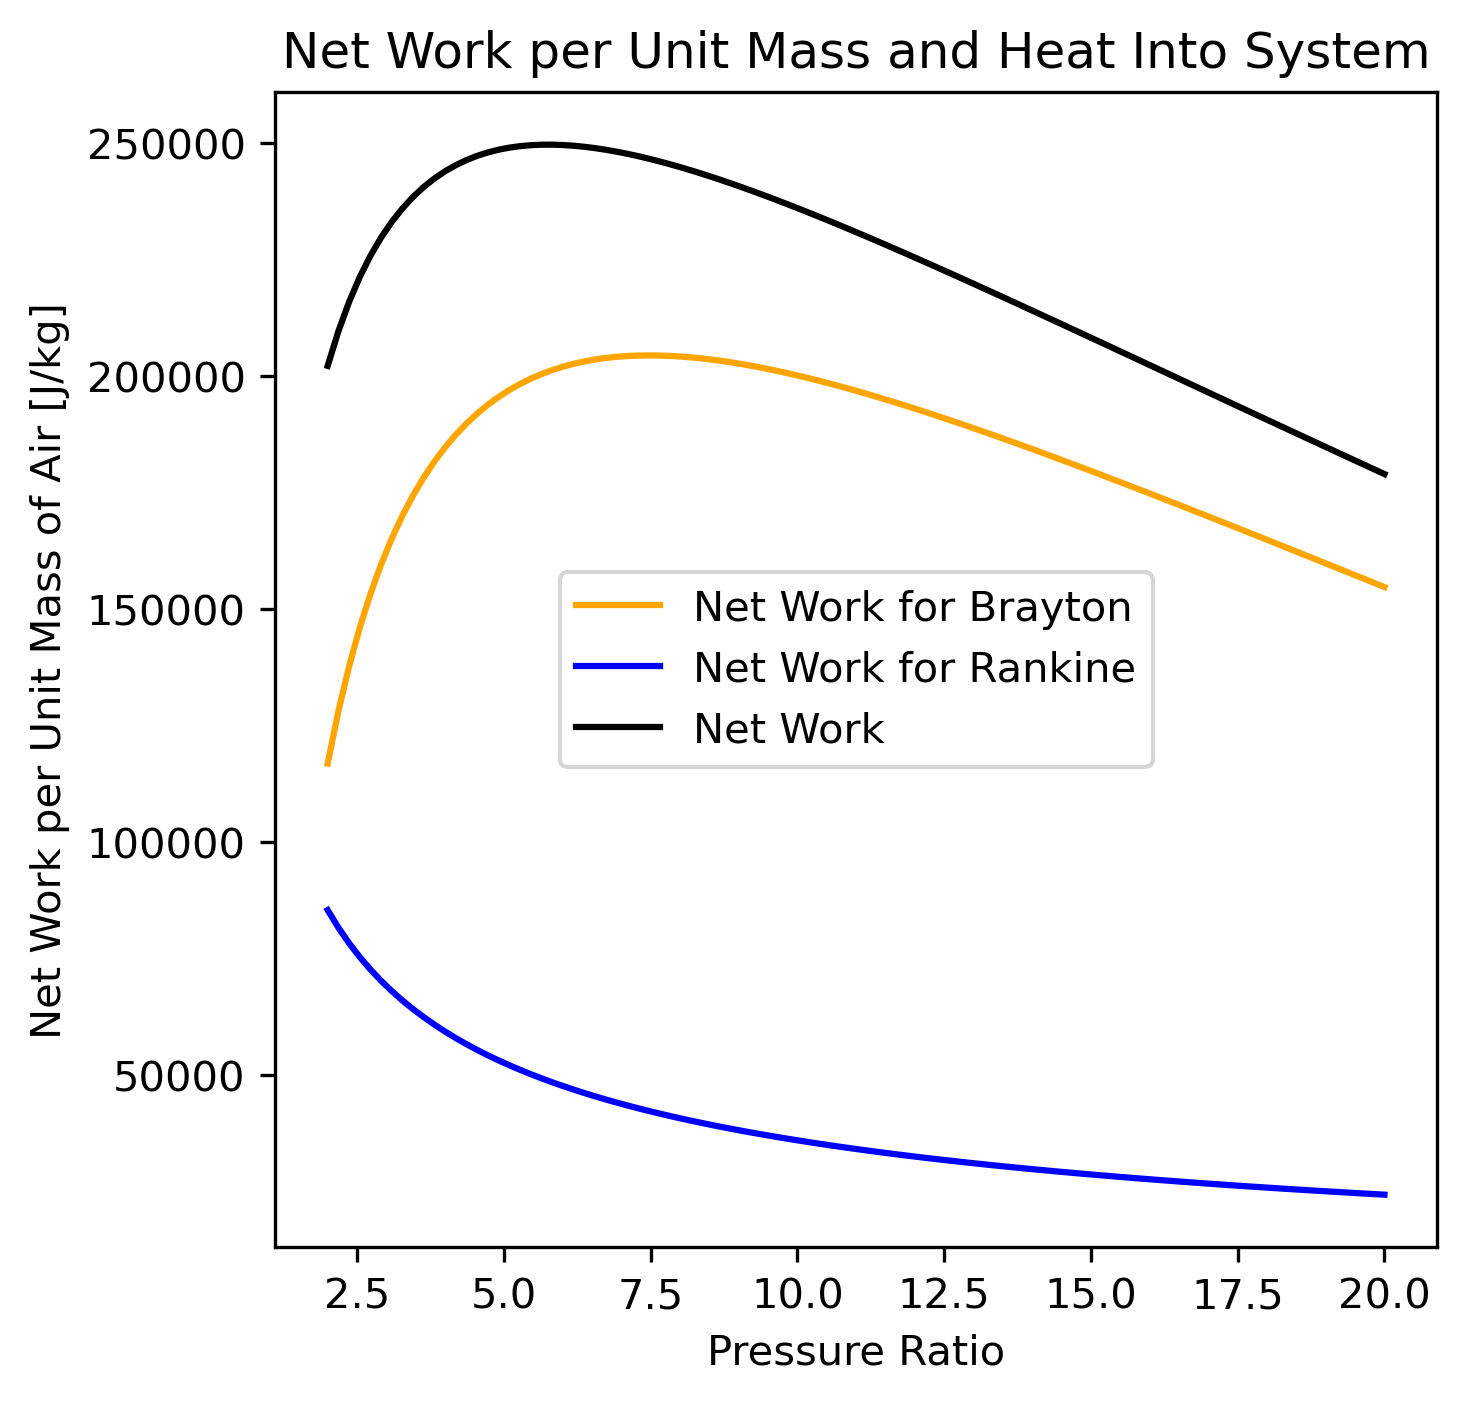

In [83]:
fig3 = plt.figure(figsize= (5,5), dpi=300)
#fig3.set_tight_layout(True)
ax4 = fig3.add_subplot(111)
ax4.plot(efficiency["Pressure Ratio"], brayton_cycle_turbine["Work"] - brayton_cycle_compressor["Work"], label="Net Work for Brayton", color="orange")
ax4.plot(efficiency["Pressure Ratio" ], (rankine_cycle_turbine["Work"] - rankine_cycle_pump["Work"]) * efficiency["Mass Ratio"], label="Net Work for Rankine", color="blue")
ax4.plot(efficiency["Pressure Ratio"], brayton_cycle_turbine["Work"] - brayton_cycle_compressor["Work"] + (rankine_cycle_turbine["Work"] - rankine_cycle_pump["Work"]) * efficiency["Mass Ratio"], label="Net Work", color="black")
ax4.set_xlabel("Pressure Ratio")
ax4.set_ylabel("Net Work per Unit Mass of Air [J/kg]")
ax4.set_title("Net Work per Unit Mass and Heat Into System")
ax4.legend()

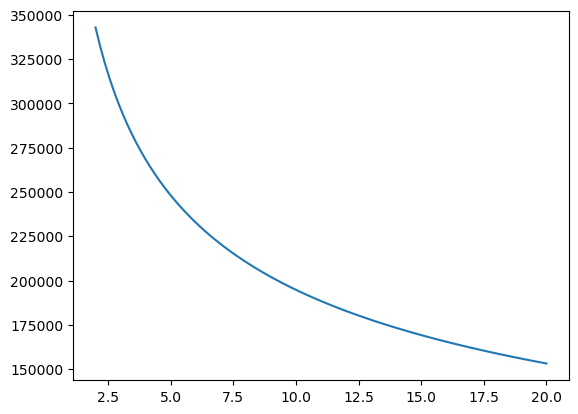

In [84]:
plt.plot(efficiency['Pressure Ratio'], rankine_cycle_turbine['Work'], label="Rankine Turbine")

In [85]:
rankine_cycle_pump['Work']

0     1953.134330
1     1925.662901
2     1900.357928
3     1876.908786
4     1855.067259
         ...     
95    1255.753821
96    1253.067094
97    1250.407925
98    1247.775790
99    1245.170181
Name: Work, Length: 100, dtype: float64

In [86]:
rankine_cycle_turbine['Work']

0     342872.924615
1     332457.136575
2     323162.160052
3     314794.512829
4     307204.968680
          ...      
95    155193.610253
96    154690.521229
97    154193.727578
98    153703.092349
99    153218.482799
Name: Work, Length: 100, dtype: float64

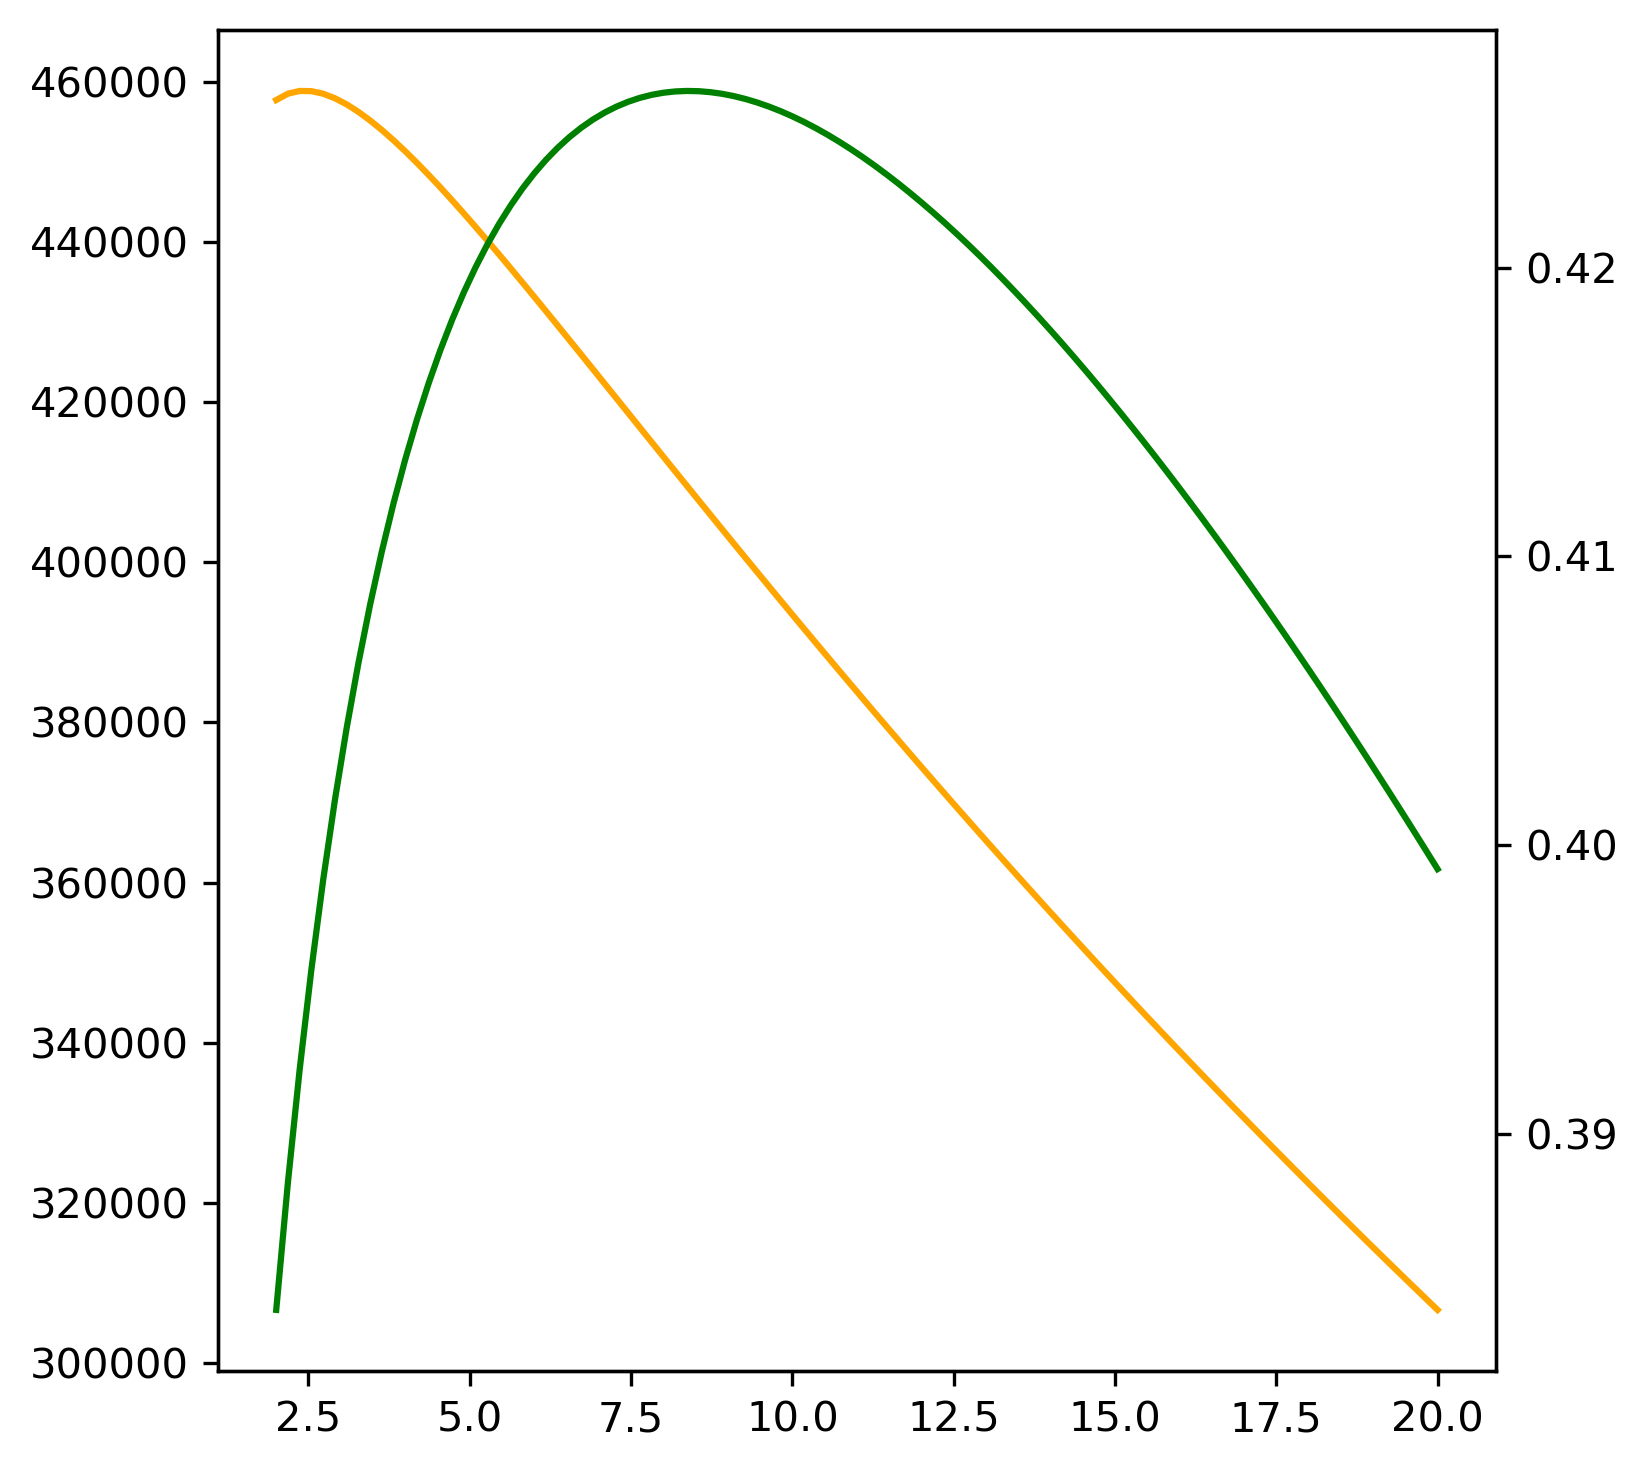

In [87]:
fig = plt.figure(figsize= (10,5), dpi=300)
fig.set_tight_layout(True)
ax = fig.add_subplot(121)
ax.plot(efficiency["Pressure Ratio"], efficiency["Net Work"], label="Net Work per Unit Mass", color="orange")
ax2 = ax.twinx()
ax2.plot(efficiency["Pressure Ratio"], efficiency["Thermal Efficinency"], label="Thermal Efficiency", color="green")